In [1]:
# Common libraries
import pandas as pd
import numpy as np
import urllib.parse
import time
import os
from matplotlib import pyplot as plt
from datetime import datetime

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Global variables
IMAGE_DIMENSION = 64

In [2]:
min_nr_images_per_class = 1e4
# Model training
threshold = 0.2         # TODO: one threshold per class?
learning_rate = 0.0001  # TODO: perhaps make it gradually decreasing?
epochs = 50
oversampling = False
use_class_weights = True
# ---------------------------

# To speed-up testing, use pre-saved model and predictions:
use_presaved_model = False
use_presaved_predictions = False

results_path = os.getcwd() + '/results/' + datetime.now().strftime('%d-%m-%Y_%H:%M:%S')

In [3]:
class DataLoader:
    def __init__(self, filename, min_nr_images_per_class, image_dimension, results_path, plot_distribution=False):
        self.filename = filename
        self.image_dimension = image_dimension
        self.min_nr_images_per_class = min_nr_images_per_class
        self.plot_distribution = plot_distribution
        self.results_path = results_path
        print('Loading dataframe...')
        self.data = self.load_dataframe()
        print('Finished loading dataframe! Started cleaning dataframe...')
        self.data = self.clean_dataframe(self.data)
        print(f'Finished loading and cleaning dataframe! It has {self.data.shape[0]} images.')

    def load_dataframe(self):
        """
        Load dataframe containing labels for each image, update its encoding and
        parses the image path in the folder /scratch/WIT_Dataset/images folder.
        """
        df = pd.read_json(self.filename, compression='bz2')
        # Make sure all images have '/commons/' in their path, otherwise they apparently aren't in the WIT_Dataset
        df = df[df.image_url.str.contains('/commons/')]
        # After /commons/ comes the file location as it is organized in the WIT_dataset
        df['image_path'] = [url.split('commons/')[1] for url in df.image_url]
        # Decode filename paths so they are validated by tensorflow later
        df['image_path'] = df['image_path'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
        return df
    
    def clean_dataframe(self, df):
        """
        Removes categories with less than min_nr_images_per_class from the dataframe self.data, 
        and removes the images that were only belonging to these classes from the data dataframe.
        Plots the distribution of images per class (the red ones are the removed).
        """
        _generator = ImageDataGenerator(rescale=1/255, fill_mode='nearest') 
        _data = _generator.flow_from_dataframe(dataframe=self.data, 
                                               directory='/scratch/WIT_Dataset/images', 
                                               x_col='image_path', 
                                               y_col='taxo_labels', 
                                               class_mode='categorical', 
                                               validate_filenames=False, 
                                               target_size=(self.image_dimension, self.image_dimension))
        y_true = get_y_true(_data.classes)
        indices_of_classes_to_remove = np.where(np.sum(y_true, axis=0) < self.min_nr_images_per_class)
        classes_to_remove = np.array(list(_data.class_indices.keys()))[indices_of_classes_to_remove] 
        df['taxo_labels'] = df['taxo_labels'].apply(lambda labels: [el for el in labels if el not in classes_to_remove])
        
        if self.plot_distribution:
            sorted_indices = np.argsort(np.sum(y_true, axis=0))
            sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]
            # print('Number of images per class')
            # print(sorted_images_per_class)
            mask_kept = y_true.sum(axis=0)[sorted_indices] > self.min_nr_images_per_class
            mask_removed = y_true.sum(axis=0)[sorted_indices] < self.min_nr_images_per_class
            plt.figure(figsize=(12, 15))
            plt.title('Number of images per class (log-scale on x-axis)')
            plt.barh(np.array(range(y_true.shape[1]))[mask_kept], sorted_images_per_class[mask_kept], color='blue', alpha=0.65)
            plt.barh(np.array(range(y_true.shape[1]))[mask_removed], sorted_images_per_class[mask_removed], color='red', alpha=0.65)
            plt.yticks(range(y_true.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
            plt.xscale('log')
            plt.xlabel('Count')
            plt.grid(True)
            plt.legend(['Kept', 'Removed'], loc='upper right')
            # plt.savefig(f'{self.results_path}/class_distribution.png')

        return df

In [59]:
def get_y_true(classes, preset_nr_classes=0):
    """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
    nr_images = len(classes)
    if not preset_nr_classes:
        nr_classes = len(set([item for sublist in classes for item in sublist]))
    else:
        nr_classes = preset_nr_classes
    y_true = np.zeros((nr_images, nr_classes))
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

def plot_distribution(classes, class_names=[], description='None', plot_log=False, lims=()):
    y_true = get_y_true(classes)
    sorted_indices = np.argsort(np.sum(y_true, axis=0))
    sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]
    plt.figure(figsize=(12, 15))
    plt.title('Number of images per class' + description)
    if plot_log:
        plt.xscale('log')
    if lims:
        plt.xlim(lims)
    plt.xlabel('Count')
    plt.grid(True)
    plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='blue', alpha=0.65)
    if class_names:
        plt.yticks(range(y_true.shape[1]), np.array(list(class_names))[sorted_indices])

def measure_balance(classes):
    """ 
    Measure of class distribution balance. 0 for unbalanced dataset, 1 for balanced. 
    Input: np.array()
    Ref: https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance
    """
    y_true = get_y_true(classes)
    nr_images_per_class = y_true.sum(axis=0)
    nr_images, nr_classes = y_true.shape
    entropy = -np.sum([(c_i/nr_images) * np.log((c_i/nr_images)) for c_i in nr_images_per_class])
    balance = entropy / np.log(nr_classes)
    # assert(balance >= 0 and balance <= 1)
    return balance

Loading dataframe...
Finished loading dataframe! Started cleaning dataframe...
Found 1040389 non-validated image filenames belonging to 64 classes.
Finished loading and cleaning dataframe! It has 1040389 images.


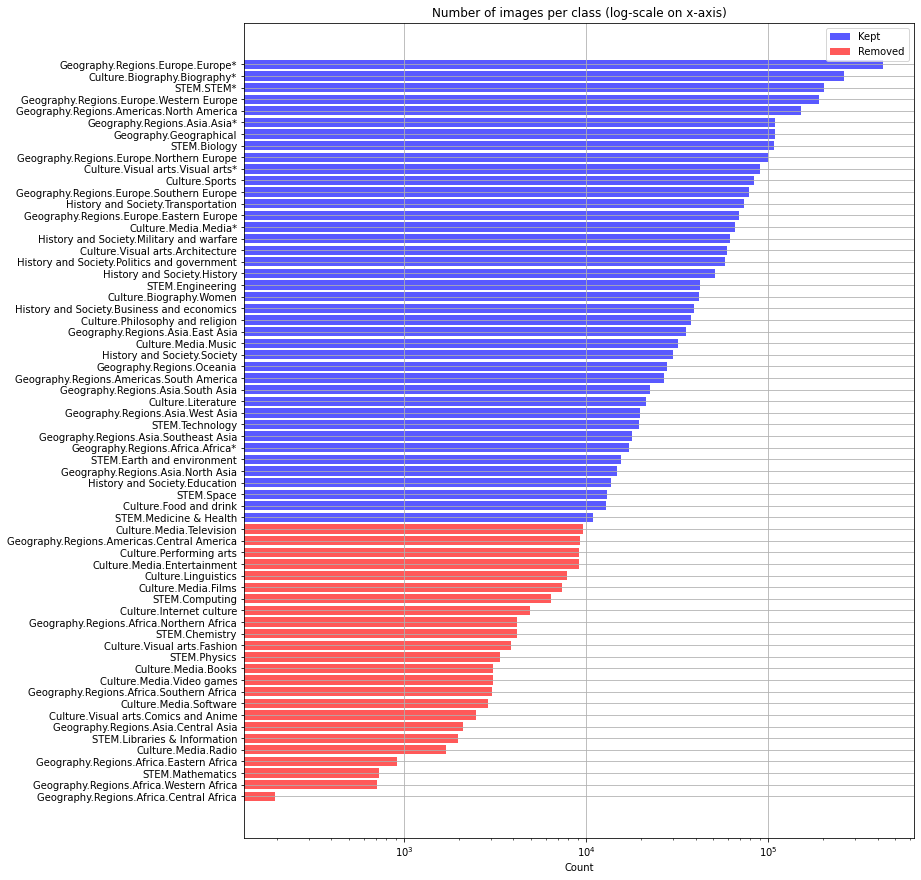

In [5]:
segments_0 = 'data/image_labels.json.bz2'
loader = DataLoader(segments_0, min_nr_images_per_class, 64, results_path, plot_distribution=True)

In [60]:
class DataSeparator:
    def __init__(self, image_label_df, oversampling=False):

        self.train_df, self.test_df = train_test_split(image_label_df, test_size=0.1, random_state=17)
        self.train_df, self.val_df = train_test_split(self.train_df, train_size=0.9, random_state=17)

        # Data generator for training and validation sets
        if oversampling:
            train_generator = ImageDataGenerator(validation_split=0.10,  rescale=1/255,
                                                 rotation_range=40,      width_shift_range=0.2,
                                                 height_shift_range=0.2, shear_range=0.2,
                                                 zoom_range=0.2,         horizontal_flip=True, fill_mode='nearest') 
        else:
            train_generator = ImageDataGenerator(validation_split=0.10, rescale=1/255)
                        
        print('\n----------- Train images -----------')
        self.train = train_generator.flow_from_dataframe(dataframe=self.train_df,  directory='/scratch/WIT_Dataset/images', 
                                                         x_col='image_path',       y_col='taxo_labels', 
                                                         class_mode='categorical', subset='training',
                                                         validate_filenames=True,  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
                                                         ) # the dimensions to which all images found will be resized.

        print('\n----------- Validation images -----------')          
        self.val = train_generator.flow_from_dataframe(dataframe=self.val_df,    directory='/scratch/WIT_Dataset/images', 
                                                       x_col='image_path',       y_col='taxo_labels', 
                                                       class_mode='categorical', subset='validation',
                                                       validate_filenames=False,  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
        # plot_distribution(self.val, 'validation')

        # Data generator for test set
        print('\n----------- Test images -----------')
        test_generator = ImageDataGenerator(rescale=1/255)
        self.test = test_generator.flow_from_dataframe(dataframe=self.test_df,    directory='/scratch/WIT_Dataset/images', 
                                                       x_col='image_path',       y_col='taxo_labels', 
                                                       class_mode='categorical',
                                                       validate_filenames=True,  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
                                                    #    save_to_dir='/home/matvieir/wiki_image_classification/classification/data/augmentations'
                                                       )
        plot_distribution(self.test.classes, self.test.class_indices.keys(), 'test before balance')
        self.test_df['label_nrs'] = self.test_df['taxo_labels'].apply(lambda labels : [self.test.class_indices[label] for label in labels] )
        self.balanced_test_df = self.balance_test() 
        self.test = test_generator.flow_from_dataframe(dataframe=self.balanced_test_df,    directory='/scratch/WIT_Dataset/images', 
                                                       x_col='image_path',       y_col='taxo_labels', 
                                                       class_mode='categorical',
                                                       validate_filenames=False,  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
                                                    #    save_to_dir='/home/matvieir/wiki_image_classification/classification/data/augmentations'
                                                       )
        plot_distribution(self.test.classes, self.test.class_indices.keys(), 'test balanced')
        
    def balance_test(self):
        """ 
        Constructs a sort of more balanced test set in a dummy way by adding to it only the images that contain 
        the - for the moment - most uncommon class. Compare the class distribution with the normal test set to 
        see it is ok balanced.
        """
        y_true = get_y_true(self.test.classes)
        sorted_indices = np.argsort(np.sum(y_true, axis=0))
        balanced_classes = []
        row_ids = []
        least_common_class_id = sorted_indices[0]
        counter = 0 
        for index, row in self.test_df.iterrows():
            counter += 1
            if counter % 10 == 0:
                y_true = get_y_true(balanced_classes, 40)
                sorted_indices = np.argsort(np.sum(y_true, axis=0)) 
                least_common_class_id = sorted_indices[0]
            if least_common_class_id in row.label_nrs:
                balanced_classes.append(row.label_nrs)
                row_ids.append(index)

        return self.test_df.loc[row_ids, :]

        # for row_id, classes in enumerate(separator.test.classes):
        #     if least_common_class_id not in classes:
        #         temp = balanced_classes.copy()
        #         temp.append(classes)
        #         if measure_balance(get_y_true(temp)) > balance_metric:
        #             balanced_classes = temp
        #             row_ids.append(row_id)
        # balance_metric = measure_balance(get_y_true(balanced_classes))


----------- Train images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 31962 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 729678 validated image filenames belonging to 40 classes.

----------- Validation images -----------
Found 9363 non-validated image filenames belonging to 40 classes.

----------- Test images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3921 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 100118 validated image filenames belonging to 40 classes.


<ipython-input-60-efa8497293b2>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_df['label_nrs'] = self.test_df['taxo_labels'].apply(lambda labels : [self.test.class_indices[label] for label in labels] )


Found 1987 non-validated image filenames belonging to 40 classes.


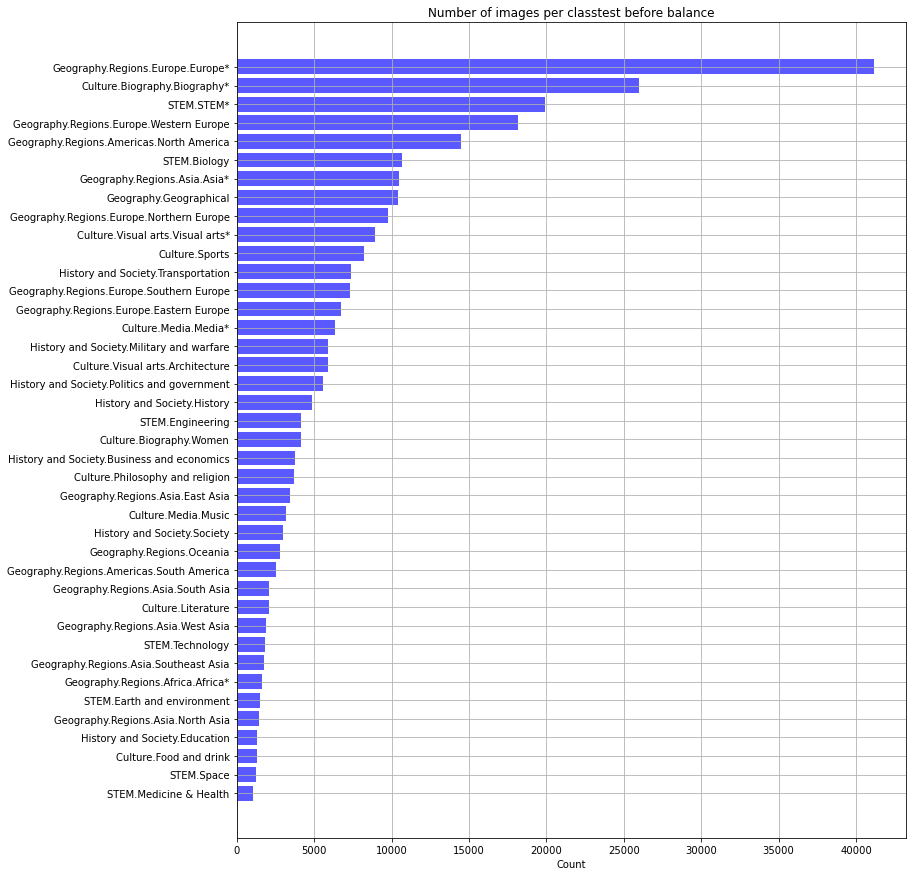

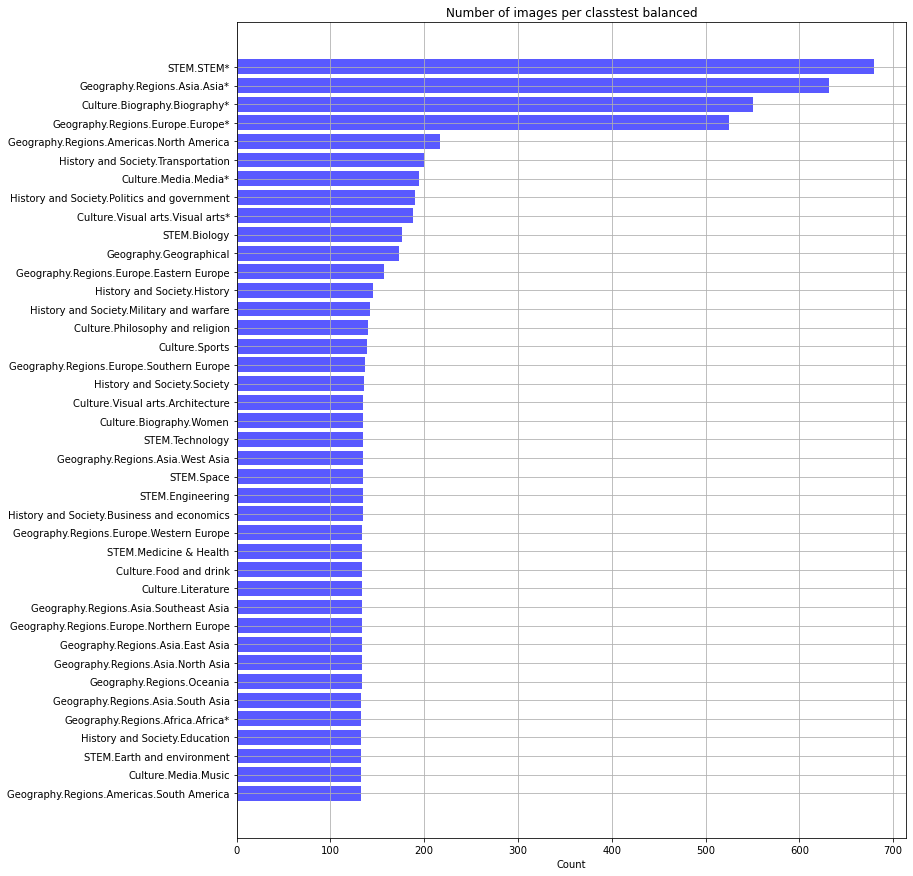

In [61]:
separator = DataSeparator(loader.data, oversampling)

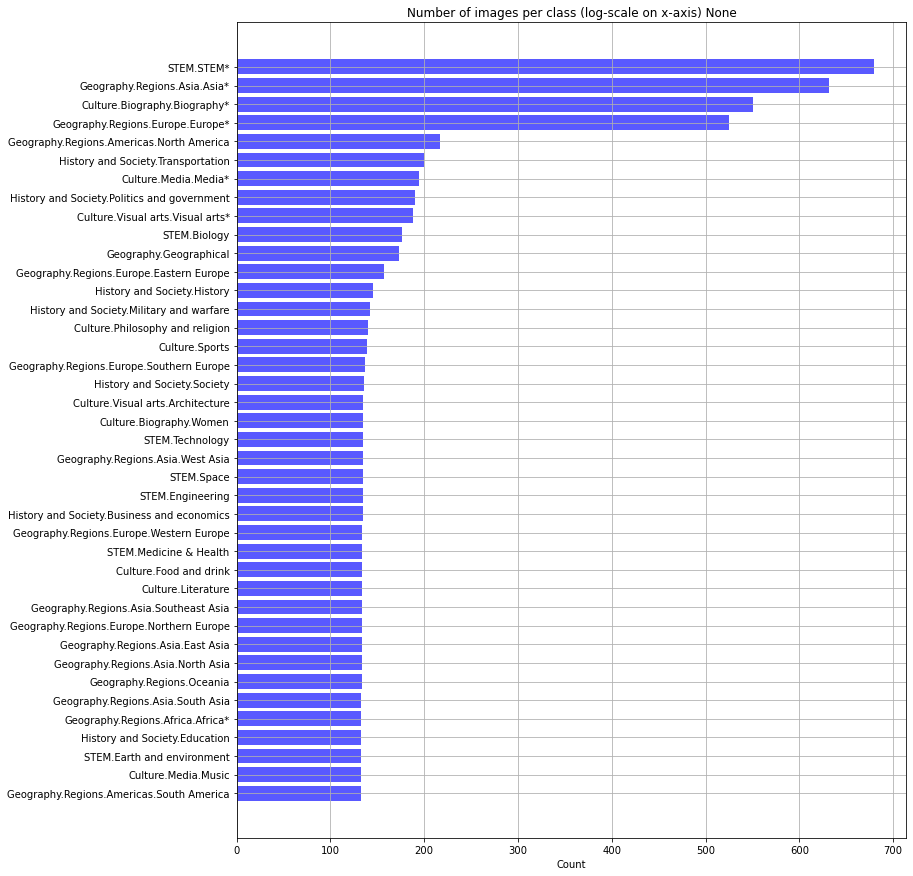

In [51]:
y_true = get_y_true(separator.test.classes)
sorted_indices = np.argsort(np.sum(y_true, axis=0))
balanced_classes = []
row_ids = []
least_common_class_id = sorted_indices[0]
counter = 0 
for index, row in separator.test_df.iterrows():
    counter += 1
    if counter % 10 == 0:
        y_true = get_y_true(balanced_classes, 40)
        sorted_indices = np.argsort(np.sum(y_true, axis=0)) 
        least_common_class_id = sorted_indices[0]
    if least_common_class_id in row.label_nrs:
        balanced_classes.append(row.label_nrs)
        row_ids.append(index)
plot_distribution(balanced_classes, class_names=separator.test.class_indices.keys())

In [4]:
class ModelTrainer:
    def __init__(self, train, val, learning_rate, results_path, epochs=50, use_class_weights=False):
        self.train = train
        self.val = val
        self.n_classes = len(train.class_indices)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.results_path = results_path
        self.use_class_weights = use_class_weights
        self.model = self.construct_model()
    
        history = self.train_model()
        self.plot_history(history)

    def construct_model(self):
        """
        Construct model in a transfer learning manner: use all weights of the EfficientNetB0 network pre-trained on 
        ImageNet-1k, and add a fully connect layer plus an output layer (with the sigmoid function as activation function). 
        - EfficientNet: https://keras.io/api/applications/efficientnet/
        - Sigmoid activation function on a multi-label classification problem: https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede
        """
        efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=self.n_classes,
                                       input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3))
        efficient_net.trainable = False
        model = Sequential()
        model.add(efficient_net)
        model.add(Flatten())
        model.add(Dense(units=120, activation='relu'))
        model.add(Dense(units=self.n_classes, activation='sigmoid')) # output layer
        model.summary() 
        with open(f'{self.results_path}/model_summary.txt', 'w') as fh:
            model.summary(print_fn=lambda x: fh.write(x + '\n'))

        tf.keras.utils.plot_model(
            model,
            to_file="model.png",
            show_shapes=False,
            show_dtype=False,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=False,
            dpi=96,
            layer_range=None,
            show_layer_activations=False,
        )
        
        return model

    def train_model(self):
        """
        Compile and train model using the binary cross entropy as loss function.
        - On what loss function to choose: https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary
        """
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy', metrics=['accuracy']) 
        if self.use_class_weights:
            class_weights = self.compute_class_weights(self.train)
            history = self.model.fit(self.train, epochs=self.epochs, steps_per_epoch=15, 
                                 validation_data=self.val, validation_steps=7,
                                 verbose=2, 
                                 class_weight=class_weights)
        else:
            history = self.model.fit(self.train, epochs=self.epochs, steps_per_epoch=15, 
                                 validation_data=self.val, validation_steps=7,
                                 verbose=2)
        return history

    def compute_class_weights(train):
        """
        Computes class_weights to compensate imbalanced classes. Inspired in 
        'https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99'.
        Dictionary mapping class indices (integers) to a weight (float) value, 
        used for weighting the loss function (during training only).
        """
        y_true = np.zeros((train.samples, len(train.class_indices))) # nr_rows=nr_images; nr_columns=nr_classes
        for row_idx, row in enumerate(train.classes):
            for idx in row:
                y_true[row_idx, idx] = 1

        class_count = y_true.sum(axis=0)
        n_samples = y_true.shape[0] 
        n_classes = y_true.shape[1]

        # Compute class weights using balanced method
        class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
        class_labels = range(len(class_weights))
        return dict(zip(class_labels, class_weights))
    
    def plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(self.epochs)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(-0.01, 0.4)
        plt.grid(True)
        plt.plot(epochs_range, acc, label='Training accuracy')
        plt.plot(epochs_range, val_acc, label='Validation accuracy')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(-0.01, 0.6)
        plt.grid(True)
        plt.plot(epochs_range, loss, label='Training loss')
        plt.plot(epochs_range, val_loss, label='Validation loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.savefig(f'{self.results_path}/train_val_loss.png')


In [5]:
class Evaluator:
    def __init__(self, test_df, model, results_path, use_presaved_predictions=False, threshold=0.2):
        """
        - threshold: if the output generated by the corresponding output neuron is greater than threshold -> object detected
        """
        self.model = model
        self.test = self.get_generator_test_set(test_df)
        self.threshold = threshold
        self.results_path = results_path
        print('Evaluating model on test set and generating metrics...')
        self.metrics = {}
        self.evaluate_and_plot(use_presaved_predictions)

    def get_generator_test_set(self, test_df):
        test_generator = ImageDataGenerator(rescale=1/255) 
        return test_generator.flow_from_dataframe(dataframe=test_df,        directory='/scratch/WIT_Dataset/images',
                                                  x_col='image_path',       y_col='taxo_labels', 
                                                  class_mode='categorical', validate_filenames=True,
                                                  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

    def evaluate_and_plot(self, use_presaved_predictions):
        # Predictions
        if not use_presaved_predictions:
            print('Predicting probabilities for test set...')
            predictions = self.model.predict(self.test, verbose=1)
            with open('checkpoints/predictions', 'wb') as f:
                np.save(f, predictions)
            with open(f'{self.results_path}/1000_lines_of_predictions.txt', 'w') as f:
                np.savetxt(f, predictions[0:1000, :], fmt='%1.5f')
        else:
            print('Using pre-saved predictions...')
            with open('checkpoints/predictions', 'rb') as f:
                predictions = np.load(f)
        y_pred = 1 * (predictions > self.threshold)
        y_true = np.zeros(y_pred.shape)
        for row_idx, row in enumerate(self.test.classes):
            for idx in row:
                y_true[row_idx, idx] = 1

        n_classes = y_true.shape[1]
        metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(self.test.class_indices), output_dict=True)).transpose()
        metrics_df['index'] = np.concatenate((np.arange(start=0, stop=n_classes), [None, None, None, None]))
        
        # Output macro and micro accuracies
        with open(f'{self.results_path}/per_class_metrics', 'w') as f:
            metrics_df.to_string(f)
        print(metrics_df.tail(4))

        # Average precision score
        # The average_precision_score function computes the average precision (AP) from prediction scores. 
        # The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction 
        # of positive samples.
        print('\nAverage precision scores (macro and weighted):')
        print(average_precision_score(y_true, y_pred, average='macro'))
        print(average_precision_score(y_true, y_pred, average='weighted'))

        # ROC AUC score
        print('\n ROC AUC score:')
        print(roc_auc_score(y_true, predictions))

        # Precision and recall for each class
        fig, axs = plt.subplots(1, 2, figsize=(12,12))

        # Precision
        sorted_indices_precision = np.argsort(metrics_df.precision[0:n_classes])
        sorted_precisions_per_class = metrics_df.precision[0:n_classes][sorted_indices_precision]
        # Recall
        sorted_indices_recall = np.argsort(metrics_df.recall[0:n_classes])
        sorted_recalls_per_class = metrics_df.recall[0:n_classes][sorted_indices_recall]
        # Plot!
        axs[0].set_title('Precision per class')
        axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
        axs[0].set_yticks(range(n_classes))
        axs[0].set_yticklabels(np.array(list(self.test.class_indices.keys()))[sorted_indices_precision])
        axs[0].set_xlabel('Precision')
        axs[0].grid(True)
        axs[1].set_title('Recall per class')
        axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
        axs[1].set_yticks(range(n_classes))
        axs[1].set_yticklabels([])
        axs[1].set_xlabel('Recall')
        axs[1].grid(True)
        plt.savefig(f'{self.results_path}/precision_recall.png')

        self.metrics['average precision score (macro)'] = average_precision_score(y_true, y_pred, average='macro')
        self.metrics['average precision score (weighted)'] = average_precision_score(y_true, y_pred, average='weighted')
        self.metrics['ROC AUC score'] = roc_auc_score(y_true, y_pred)
 

In [7]:
from tensorflow.keras.preprocessing.image import load_img

